In [ ]:
"""
author: Mu Yibo 
institution: Northeastern University
date: 2022/5

"""

'\nauthor: Mu Yibo \ninstitution: Northeastern University\ndate: 2022/5\n\n'

In [ ]:
!rm -rf data
!mkdir data
!unzip -d /content/data /content/drive/MyDrive/data/aptos2019-blindness-detection.zip

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.1 MB/s 


In [ ]:
%matplotlib inline
# 导入相关库
import os
import sys

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from torchvision.io import read_image
from torch.optim.lr_scheduler import StepLR

from PIL import Image
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import timm
from timm.data.transforms_factory import create_transform

In [ ]:
# 设置相关参数
batch_size = 16
epochs = 30
lr = 5e-5

num_classes = 4
image_size = 380

device = "cuda" if torch.cuda.is_available() else "cpu"

labels_map = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
#    4: "Proliferative DR",
}
coef = [0.5, 1.5, 2.5, 3.5]

In [ ]:
def predict_class(value):
  pre = 0
  if value < coef[0]:
    pre = 0.0
  elif value >= coef[0] and value < coef[1]:
    pre = 1.0
  elif value >= coef[1] and value < coef[2]:
    pre = 2.0
  else:
    pre = 3.0

  return pre

## 1.导入数据集并进行图像预处理

In [ ]:
## code from https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy?scriptVersionId=20340219
# 图像预处理函数
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
# 使用上面的函数进行图像预处理
# 仅当需要输出预处理后图片到文件夹中时才使用此单元格
input_path = 'data'
train_path = input_path + '/train_images'
test_path = input_path + '/test_images'

train_output_path = input_path + '/preprocessed_train_images'
test_output_path = input_path + '/preprocessed_test_images'

try:
    os.mkdir(train_output_path)
    os.mkdir(test_output_path)
except:
    print("Dictionary already exists")

# 处理训练集数据
for image_path in tqdm(os.listdir(train_path)):
    input_image = os.path.join(train_path, image_path)

    image = cv2.imread(input_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (image_size, image_size))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 30), -4, 128)

    output_image = os.path.join(train_output_path, image_path)
    cv2.imwrite(output_image, image)

# 处理测试集数据
for image_path in tqdm(os.listdir(test_path)):
    input_image = os.path.join(test_path, image_path)

    image = cv2.imread(input_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (image_size, image_size))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 30), -4, 128)

    output_image = os.path.join(test_output_path, image_path)
    cv2.imwrite(output_image, image)


Dictionary already exists


100%|██████████| 1928/1928 [03:20<00:00,  9.64it/s]


## 1.a 使用数字标签，转换为torch.tensor，此时num_classes == 1

In [ ]:
# 设置path参数，导入csv标签，划分训练集和验证集
input_path = 'data'
train_path = input_path + '/train_images'
test_path = input_path + '/test_images'

train_output_path = input_path + '/preprocessed_train_images'
test_output_path = input_path + '/preprocessed_test_images'

# 读取csv annotation file
df_train = pd.read_csv(input_path + '/train.csv')
df_test = pd.read_csv(input_path + '/test.csv')

# drop label == 4   295 images
df_train.drop(df_train[df_train.diagnosis == 4].index, inplace=True) 
df_train.reset_index(drop=True, inplace=True)
#df_train.hist()
#x = df_train['id_code']      #images
#y = df_train['diagnosis']    #labels

train_list, valid_list = train_test_split(df_train, test_size=0.1, random_state=42)
test_list = df_test
print(len(df_train))
print(len(train_list))
print(len(valid_list))

3367
3030
337


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f27cb485a90>]],
      dtype=object)

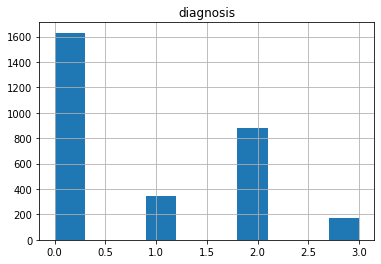

In [ ]:
train_list.hist()

In [ ]:
# class APTOSDataset(Dataset):
#     def __init__(self, annotations_dataframe, img_dir, transform=None, target_transform=None):
#         self.img_labels = annotations_dataframe
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform
    
#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         img_path = img_path + '.png'
        

#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = crop_image_from_gray(image)
#         image = cv2.resize(image, (image_size, image_size))
#         image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 30), -4, 128)

#         image = transforms.ToPILImage()(image)
        
#         label = torch.tensor(self.img_labels.iloc[idx, 1])

#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)

#         return image, label
class APTOSDataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = img_path + '.png'
        #image = read_image(img_path)
        image = Image.open(img_path)
        #label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
# 定义transforms
train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
)

In [ ]:
train_transforms_timm = create_transform(image_size, is_training=True, auto_augment='rand-m9-mstd0.5')
train_transforms_timm

Compose(
    RandomResizedCropAndInterpolation(size=(380, 380), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Posterize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Solarize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Color, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Contrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Brightness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Sharpness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=9, mstd=0.5))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.

In [ ]:
train_dir = 'data/preprocessed_train_images'
test_dir = 'data/preprocessed_test_images'

train_dataset = APTOSDataset(train_list, train_dir, transform=train_transforms_timm)
valid_dataset = APTOSDataset(valid_list, train_dir, transform=train_transforms_timm)
test_dataset = APTOSDataset(test_list, test_dir, transform=test_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(train_dataloader))
print(len(valid_dataset), len(valid_dataloader))
print(len(test_dataset), len(test_dataloader))

3030 48
337 6
1928 31


## 1.b 使用扩展的one-hot编码作为标签

In [ ]:
num_classes = 4  #reset num_classes because of the change of labels

In [ ]:
# 设置path参数，导入csv标签，划分训练集和验证集
input_path = 'data'
train_path = input_path + '/train_images'
test_path = input_path + '/test_images'

train_output_path = input_path + '/preprocessed_train_images'
test_output_path = input_path + '/preprocessed_test_images'

# 读取csv annotation file
df_train = pd.read_csv(input_path + '/train.csv')
df_test = pd.read_csv(input_path + '/test.csv')

# drop label == 4   295 images
df_train.drop(df_train[df_train.diagnosis == 4].index, inplace=True) 
df_train.reset_index(drop=True, inplace=True)
#df_train.hist()
#x = df_train['id_code']      #images
#y = df_train['diagnosis']    #labels

train_list, valid_list = train_test_split(df_train, test_size=0.1, random_state=42)
test_list = df_test
print(len(df_train))
print(len(train_list))
print(len(valid_list))
# print(len(valid_list))

3367
3030
337


In [ ]:
# 重载Dataset类
class APTOSDataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = img_path + '.png'
        #image = read_image(img_path)
        image = Image.open(img_path)
        #label = self.img_labels.iloc[idx, 1]
        label_ori = self.img_labels.iloc[idx, 1]
        if label_ori == 0:
          label = torch.tensor([1, 0, 0, 0])
        elif label_ori == 1:
          label = torch.tensor([1, 1, 0, 0])
        elif label_ori == 2:
          label = torch.tensor([1, 1, 1, 0])
        else:
          label = torch.tensor([1, 1, 1, 1])
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
)

train_transforms_timm = create_transform(image_size, is_training=True, auto_augment='rand-m9-mstd0.5')
target_transform = transforms.Lambda(lambda y: torch.zeros(num_classes, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [ ]:
train_dir = 'data/preprocessed_train_images'
test_dir = 'data/preprocessed_test_images'

train_dataset = APTOSDataset(train_list, train_dir, transform=train_transforms_timm)
valid_dataset = APTOSDataset(valid_list, train_dir, transform=train_transforms_timm)
test_dataset = APTOSDataset(test_list, test_dir, transform=test_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(train_dataloader))
print(len(valid_dataset), len(valid_dataloader))
print(len(test_dataset), len(test_dataloader))

3030 95
337 11
1928 61


## 1.c 使用int型的数字标签，跟MNIST数据集的标签类型相同

In [ ]:
# 设置path参数，导入csv标签，划分训练集和验证集
input_path = 'data'
train_path = input_path + '/train_images'
test_path = input_path + '/test_images'

train_output_path = input_path + '/preprocessed_train_images'
test_output_path = input_path + '/preprocessed_test_images'

# 读取csv annotation file
df_train = pd.read_csv(input_path + '/train.csv')
df_test = pd.read_csv(input_path + '/test.csv')

# drop label == 4   295 images
df_train.drop(df_train[df_train.diagnosis == 4].index, inplace=True) 
df_train.reset_index(drop=True, inplace=True)
#df_train.hist()
#x = df_train['id_code']      #images
#y = df_train['diagnosis']    #labels

train_list, valid_list = train_test_split(df_train, test_size=0.1, random_state=42)
test_list = df_test
print(len(df_train))
print(len(train_list))
print(len(valid_list))

3367
3030
337


In [ ]:
class APTOSDataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = img_path + '.png'
        #image = read_image(img_path)
        image = Image.open(img_path)
        #label = self.img_labels.iloc[idx, 1]
        label = int(self.img_labels.iloc[idx, 1])  
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
# 定义transforms
# train_transforms = transforms.Compose(
#     [
#         transforms.RandomResizedCrop(image_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     ]
# )

test_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
)

train_transforms_timm = create_transform(image_size, is_training=True, auto_augment='rand-m9-mstd0.5')
target_transform = transforms.Lambda(lambda y: torch.zeros(num_classes, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [ ]:
train_dir = 'data/train_images'
test_dir = 'data/test_images'

train_dataset = APTOSDataset(train_list, train_dir, transform=train_transforms_timm)
valid_dataset = APTOSDataset(valid_list, train_dir, transform=train_transforms_timm)
test_dataset = APTOSDataset(test_list, test_dir, transform=test_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(train_dataloader))
print(len(valid_dataset), len(valid_dataloader))
print(len(test_dataset), len(test_dataloader))

3030 190
337 22
1928 121


## 2.a 模型训练

In [ ]:
model = models.efficientnet_b5(pretrained=False)
#print(model)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features=in_features, out_features=num_classes)

model.load_state_dict(torch.load('effi_b5_224x224.pth'))

model.to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
save_path = 'efficientnet_b4_b.pth'

# Train the model
for epoch in range(epochs):
    # train
    print('Learning Rate: {}'.format(scheduler.get_last_lr()))
    model.train()
    train_loss = .0
    for i, (images, labels) in enumerate(tqdm(train_dataloader)):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        print(labels.shape)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    print ('Epoch [{}/{}], Train Loss: {:.4f}' .format(epoch+1, epochs, train_loss/len(train_dataloader)))

    model.eval()
    val_loss = .0
    with torch.no_grad():
      for i, (images, labels) in enumerate(valid_dataloader):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        outputs = model(image)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print('Val Loss: {:.4f}'.format(val_loss/len(valid_dataloader)))

    # validate the model, show the loss and accuarcy of the validation set
    # model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    # avg_val_loss = .0
    # with torch.no_grad():
    #     correct = 0
    #     total = 0
    #     for i, (images, labels) in enumerate(valid_dataloader):
    #         labels = labels.view(-1, 1)
    #         images = images.to(device, dtype=torch.float)
    #         labels = labels.to(device, dtype=torch.float)
    #         outputs = model(images)
            
    #         val_loss = criterion(outputs, labels)
    #         avg_val_loss += val_loss.item() / len(valid_dataloader)

    #         outputs = outputs.view(-1)
    #         labels = labels.view(-1)
    #         predicts = []
    #         for idx in outputs:
    #           predicts.append(predict_class(idx))
    #         predicts = torch.tensor(predicts).to(device)
    
    #         total += labels.size(0)
    #         correct += (predicts == labels).sum().item()

    # print('Val Loss: {:.4f}, Val Accuarcy: {:.4f} %'.format(avg_val_loss, 100*correct/total))

    scheduler.step()

# Save the model checkpoint
# torch.save(model.state_dict(), save_path)

## 2.c 模型训练

In [ ]:
model = models.efficientnet_b4(pretrained=True)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features=in_features, out_features=num_classes)

model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
save_path = 'effi_b4_300x300.pth'

epochs_train_loss = []
epochs_val_loss = []
epochs_train_acc = []
epochs_val_acc = []

best_loss = 100.0
best_acc = 0
# Train the model
total_step = len(train_dataloader)
for epoch in range(epochs):
    # train
    print('Learning Rate: {}'.format(scheduler.get_last_lr()))
    model.train()
    train_loss = 0.0
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch [{}/{}]' .format(epoch+1, epochs))
    print('Train loss: {:.4f}'.format(train_loss / len(train_dataloader)))
    epochs_train_loss.append(train_loss / len(train_dataloader))
    print('Train Accuracy of the model on the validation images: {} %'.format(100 * correct / total))
    epochs_train_acc.append(100 * correct / total)

    # validate the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Val loss: {:.4f}'.format(val_loss / len(valid_dataloader)))
    epochs_val_loss.append(val_loss / len(valid_dataloader))
    print('Val Accuracy of the model on the validation images: {} %'.format(100 * correct / total))
    epochs_val_acc.append(100 * correct / total)

    if (val_loss / len(valid_dataloader)) < best_loss:
      best_loss = val_loss / len(valid_dataloader)
    if (100 * correct / total) > best_acc:
      best_acc = 100 * correct / total
      print('Save best model,loss: {:.4f}  acc: {}'.format(best_loss, best_acc))
      torch.save(model.state_dict(), save_path)

    scheduler.step()

# Save the model checkpoint

Learning Rate: [5e-05]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [1/30]
Train loss: 1.1527
Train Accuracy of the model on the validation images: 54.224422442244226 %
Val loss: 0.8983
Val Accuracy of the model on the validation images: 62.31454005934718 %
Save best model,loss: 0.8983  acc: 62.31454005934718
Learning Rate: [5e-05]


100%|██████████| 190/190 [07:02<00:00,  2.22s/it]


Epoch [2/30]
Train loss: 0.7377
Train Accuracy of the model on the validation images: 74.91749174917491 %
Val loss: 0.5597
Val Accuracy of the model on the validation images: 78.63501483679525 %
Save best model,loss: 0.5597  acc: 78.63501483679525
Learning Rate: [5e-05]


100%|██████████| 190/190 [07:00<00:00,  2.21s/it]


Epoch [3/30]
Train loss: 0.5831
Train Accuracy of the model on the validation images: 78.58085808580859 %
Val loss: 0.4647
Val Accuracy of the model on the validation images: 83.0860534124629 %
Save best model,loss: 0.4647  acc: 83.0860534124629
Learning Rate: [2.5e-05]


100%|██████████| 190/190 [07:00<00:00,  2.21s/it]


Epoch [4/30]
Train loss: 0.5352
Train Accuracy of the model on the validation images: 80.26402640264027 %
Val loss: 0.4763
Val Accuracy of the model on the validation images: 83.67952522255193 %
Save best model,loss: 0.4647  acc: 83.67952522255193
Learning Rate: [2.5e-05]


100%|██████████| 190/190 [07:00<00:00,  2.21s/it]


Epoch [5/30]
Train loss: 0.5146
Train Accuracy of the model on the validation images: 80.56105610561056 %
Val loss: 0.5023
Val Accuracy of the model on the validation images: 82.7893175074184 %
Learning Rate: [2.5e-05]


100%|██████████| 190/190 [07:03<00:00,  2.23s/it]


Epoch [6/30]
Train loss: 0.4923
Train Accuracy of the model on the validation images: 80.6930693069307 %
Val loss: 0.4567
Val Accuracy of the model on the validation images: 83.38278931750742 %
Learning Rate: [1.25e-05]


100%|██████████| 190/190 [07:02<00:00,  2.22s/it]


Epoch [7/30]
Train loss: 0.4709
Train Accuracy of the model on the validation images: 81.74917491749174 %
Val loss: 0.4723
Val Accuracy of the model on the validation images: 83.97626112759644 %
Save best model,loss: 0.4567  acc: 83.97626112759644
Learning Rate: [1.25e-05]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [8/30]
Train loss: 0.4844
Train Accuracy of the model on the validation images: 81.32013201320132 %
Val loss: 0.4136
Val Accuracy of the model on the validation images: 85.7566765578635 %
Save best model,loss: 0.4136  acc: 85.7566765578635
Learning Rate: [1.25e-05]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [9/30]
Train loss: 0.4696
Train Accuracy of the model on the validation images: 81.74917491749174 %
Val loss: 0.4593
Val Accuracy of the model on the validation images: 83.0860534124629 %
Learning Rate: [6.25e-06]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [10/30]
Train loss: 0.4824
Train Accuracy of the model on the validation images: 81.45214521452145 %
Val loss: 0.5445
Val Accuracy of the model on the validation images: 83.38278931750742 %
Learning Rate: [6.25e-06]


100%|██████████| 190/190 [07:00<00:00,  2.21s/it]


Epoch [11/30]
Train loss: 0.4643
Train Accuracy of the model on the validation images: 81.91419141914191 %
Val loss: 0.4396
Val Accuracy of the model on the validation images: 85.16320474777449 %
Learning Rate: [6.25e-06]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [12/30]
Train loss: 0.4787
Train Accuracy of the model on the validation images: 81.51815181518151 %
Val loss: 0.4517
Val Accuracy of the model on the validation images: 82.49258160237389 %
Learning Rate: [3.125e-06]


100%|██████████| 190/190 [07:02<00:00,  2.23s/it]


Epoch [13/30]
Train loss: 0.4477
Train Accuracy of the model on the validation images: 82.67326732673267 %
Val loss: 0.4577
Val Accuracy of the model on the validation images: 83.97626112759644 %
Learning Rate: [3.125e-06]


100%|██████████| 190/190 [07:02<00:00,  2.22s/it]


Epoch [14/30]
Train loss: 0.4615
Train Accuracy of the model on the validation images: 82.17821782178218 %
Val loss: 0.4445
Val Accuracy of the model on the validation images: 84.27299703264094 %
Learning Rate: [3.125e-06]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [15/30]
Train loss: 0.4786
Train Accuracy of the model on the validation images: 81.71617161716172 %
Val loss: 0.4135
Val Accuracy of the model on the validation images: 86.05341246290801 %
Save best model,loss: 0.4135  acc: 86.05341246290801
Learning Rate: [1.5625e-06]


100%|██████████| 190/190 [07:03<00:00,  2.23s/it]


Epoch [16/30]
Train loss: 0.4585
Train Accuracy of the model on the validation images: 81.78217821782178 %
Val loss: 0.4025
Val Accuracy of the model on the validation images: 84.86646884272997 %
Learning Rate: [1.5625e-06]


100%|██████████| 190/190 [07:07<00:00,  2.25s/it]


Epoch [17/30]
Train loss: 0.4624
Train Accuracy of the model on the validation images: 81.84818481848185 %
Val loss: 0.4403
Val Accuracy of the model on the validation images: 85.16320474777449 %
Learning Rate: [1.5625e-06]


100%|██████████| 190/190 [07:02<00:00,  2.22s/it]


Epoch [18/30]
Train loss: 0.4633
Train Accuracy of the model on the validation images: 82.11221122112211 %
Val loss: 0.4264
Val Accuracy of the model on the validation images: 83.67952522255193 %
Learning Rate: [7.8125e-07]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [19/30]
Train loss: 0.4624
Train Accuracy of the model on the validation images: 81.78217821782178 %
Val loss: 0.4610
Val Accuracy of the model on the validation images: 83.67952522255193 %
Learning Rate: [7.8125e-07]


100%|██████████| 190/190 [07:02<00:00,  2.22s/it]


Epoch [20/30]
Train loss: 0.4632
Train Accuracy of the model on the validation images: 82.11221122112211 %
Val loss: 0.4317
Val Accuracy of the model on the validation images: 84.27299703264094 %
Learning Rate: [7.8125e-07]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [21/30]
Train loss: 0.4561
Train Accuracy of the model on the validation images: 82.07920792079207 %
Val loss: 0.4330
Val Accuracy of the model on the validation images: 84.27299703264094 %
Learning Rate: [3.90625e-07]


100%|██████████| 190/190 [07:04<00:00,  2.24s/it]


Epoch [22/30]
Train loss: 0.4700
Train Accuracy of the model on the validation images: 81.84818481848185 %
Val loss: 0.4203
Val Accuracy of the model on the validation images: 85.7566765578635 %
Learning Rate: [3.90625e-07]


100%|██████████| 190/190 [07:03<00:00,  2.23s/it]


Epoch [23/30]
Train loss: 0.4405
Train Accuracy of the model on the validation images: 83.06930693069307 %
Val loss: 0.4004
Val Accuracy of the model on the validation images: 85.16320474777449 %
Learning Rate: [3.90625e-07]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [24/30]
Train loss: 0.4537
Train Accuracy of the model on the validation images: 81.71617161716172 %
Val loss: 0.4187
Val Accuracy of the model on the validation images: 84.86646884272997 %
Learning Rate: [1.953125e-07]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [25/30]
Train loss: 0.4560
Train Accuracy of the model on the validation images: 82.01320132013201 %
Val loss: 0.4278
Val Accuracy of the model on the validation images: 83.97626112759644 %
Learning Rate: [1.953125e-07]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [26/30]
Train loss: 0.4607
Train Accuracy of the model on the validation images: 81.68316831683168 %
Val loss: 0.4073
Val Accuracy of the model on the validation images: 85.45994065281899 %
Learning Rate: [1.953125e-07]


100%|██████████| 190/190 [07:00<00:00,  2.21s/it]


Epoch [27/30]
Train loss: 0.4563
Train Accuracy of the model on the validation images: 82.11221122112211 %
Val loss: 0.4144
Val Accuracy of the model on the validation images: 84.86646884272997 %
Learning Rate: [9.765625e-08]


100%|██████████| 190/190 [07:01<00:00,  2.22s/it]


Epoch [28/30]
Train loss: 0.4533
Train Accuracy of the model on the validation images: 82.40924092409242 %
Val loss: 0.6855
Val Accuracy of the model on the validation images: 84.27299703264094 %
Learning Rate: [9.765625e-08]


100%|██████████| 190/190 [07:00<00:00,  2.21s/it]


Epoch [29/30]
Train loss: 0.4594
Train Accuracy of the model on the validation images: 82.40924092409242 %
Val loss: 0.4223
Val Accuracy of the model on the validation images: 85.7566765578635 %
Learning Rate: [9.765625e-08]


100%|██████████| 190/190 [07:00<00:00,  2.22s/it]


Epoch [30/30]
Train loss: 0.4661
Train Accuracy of the model on the validation images: 82.01320132013201 %
Val loss: 0.3823
Val Accuracy of the model on the validation images: 86.35014836795253 %
Save best model,loss: 0.3823  acc: 86.35014836795253


## 3.推理

In [ ]:
!cp effi_b4_300x300.pth drive/MyDrive/data

In [ ]:
coef = [0.5, 1.5, 2.5, 3.5]
def predict_class(value):
  pre = 0
  if value < coef[0]:
    pre = 0.0
  elif value >= coef[0] and value < coef[1]:
    pre = 1.0
  elif value >= coef[1] and value < coef[2]:
    pre = 2.0
  else:
    pre = 3.0

  return pre

In [ ]:
# 针对整型标签进行推理
# model = models.efficientnet_b4()
# in_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(in_features=in_features, out_features=num_classes)

# model.load_state_dict(torch.load('efficientnet_b4.pth'))
# model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(valid_dataloader):
    #labels = labels.view(-1, 1)
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    print(outputs.shape)
    print(labels.shape)
    #labels = labels.view(-1)
#     predicts = []
#     for idx in outputs:
#       predicts.append(predict_class(idx))
#     predicts = torch.tensor(predicts).to(device)
    
#     total += labels.size(0)
#     correct += (predicts == labels).sum().item()

# print('final accuarcy : {:.4f} %'.format(100 * correct / total))

In [ ]:
model = models.efficientnet_b5()
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features=in_features, out_features=num_classes)

model.load_state_dict(torch.load('effi_b5_224x224.pth'))
model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(valid_dataloader):
    #labels = labels.view(-1, 1)
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)

    outputs = model(images).view(-1)
    #labels = labels.view(-1)
    predicts = []
    for idx in outputs:
      predicts.append(predict_class(idx))
    predicts = torch.tensor(predicts).to(device)
    
    total += labels.size(0)
    correct += (predicts == labels).sum().item()

print('final accuarcy : {:.4f} %'.format(100 * correct / total))

final accuarcy : 83.0861 %
